<a href="https://colab.research.google.com/github/Anvayt24/neural-style-art-transfer/blob/main/ArtGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


loading and processing the images

In [ ]:
def preprocess_image(image_path= '/content/drive/MyDrive/Colab Notebooks/content.jpg.jpg'):
    img = load_img(image_path, target_size=(224,224))            #changing the dimensions required by VGG19
    img = img_to_array(img)                                      #converting the image to a numpy array
    img = np.expand_dims(img, axis=0)                            #adding an extra dimension to the array(batch dimension)
    img = tf.keras.applications.vgg19.preprocess_input(img)      #normalizing
    return img


visualizing the image (deprocessing it)

In [ ]:
def deprocess_image(img):
  img= img.reshape((224, 224 , 3))    #remove the batch dimension and reshape back to 3D
  img[:,:,0] += 103.939               # adding back the mean for B channel
  img[:,:,1] += 116.779               # adding back the mean for G channel
  img[:,:,2] += 123.68                 # adding back the mean for R channel
  img = img[:,:,::-1]                 # reversing the BGR to RGB
  img = np.clip(img, 0 , 255).astype('uint8')  #ensuring the values are within the valid range
  return img

loading the images

In [ ]:
content_image = preprocess_image('/content/drive/MyDrive/Colab Notebooks/content.jpg.jpg')
style_image = preprocess_image('/content/drive/MyDrive/Colab Notebooks/style.jpeg')

loading VGG19 model

In [ ]:
vgg = VGG19(weights='imagenet', include_top=False)
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


defining the model

In [ ]:
content_model = Model(inputs=vgg.input , outputs=vgg.get_layer(content_layer).output)
style_models = [Model(inputs=vgg.input, outputs=vgg.get_layer(layer).output) for layer in style_layers]


content loss

In [ ]:
def content_loss(content, combination):
  return tf.reduce_mean(tf.square(combination - content))

style loss

In [ ]:
def gram_matrix(x):                                      #gram matrix to capture texture and patterns
  x = tf.transpose(x, (3,2,0,1))                           #reordering the dimensions to (channels , height , width)
  features = tf.reshape(x, (tf.shape(x)[0], -1))         #flattening the height and weidth into a single dimension
  gram = tf.matmul(features, tf.transpose(features))     #calculating the gram matrix by matrix multiplication or dot product
  return gram

In [ ]:
def style_loss(style , combinations):
  S= gram_matrix(style)                          #gram matrix of the style of image
  C= gram_matrix(combinations)                   # gram matrix of the generated image
  return tf.reduce_mean(tf.square(S - C))        # returning the mean squared error between the two gram matrices

combining losses

In [ ]:
def compute_loss(combination_image, content_image, style_image):
  input_tensor = tf.concat([content_image, style_image, combination_image], axis=0)
  features = vgg(input_tensor)                                   #passing the concatenated tensor through VGG model
  loss = tf.zeros(())

  #content loss
  content_output = content_model(content_image)                  #extracting the content features from the content image
  combination_content = content_model(combination_image)         #extracting the content features of combination or the generated image
  loss +=  content_loss(content_output, combination_content)      #content loss is calculated and added to total loss

  #style loss
  for style_model in style_models:                               #loop over each style model
    style_output = style_model(style_image)                      #extracting teh style features from the style image
    combination_style = style_model(combination_image)           #extracting the style features of combination or the generated image
    loss +=  style_loss(style_output, combination_style)      #style loss is calculated and added to total loss

  return loss

optimizer

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.1)

tf.function

In [ ]:
def train_step(combination_image):
  with tf.GradientTape() as tape:                                          #context to record operations to produce gradients
    loss = compute_loss (combination_image , content_image , style_image)
    grads = tape.gradient(loss , combination_image)                        #compute the gradient of the loss with respect to thw combination image
    optimizer.apply_gradients([(grads , combination_image)])               # update the combination image using the optimizer and the computed gradients
    return loss

intializing the combination image

In [ ]:
combination_image = tf.Variable(content_image , dtype=tf.float32 )


running the training loop

In [ ]:
epochs = 1000
for epoch in range(epochs):
  loss = train_step(combination_image)
  if epoch % 100 == 0:
    print(f'epoch {epoch} , loss: {loss.numpy()}')

epoch 0 , loss: 2.7900351508958413e+17
epoch 100 , loss: 1.010190309612585e+17
epoch 200 , loss: 5.404377534903091e+16
epoch 300 , loss: 3.749343240650752e+16
epoch 400 , loss: 2.890118712210227e+16
epoch 500 , loss: 2.3462154355081216e+16
epoch 600 , loss: 1.9721261462585344e+16
epoch 700 , loss: 1.7042304602734592e+16
epoch 800 , loss: 1.5041479055507456e+16
epoch 900 , loss: 1.3474496744783872e+16


displaying final image

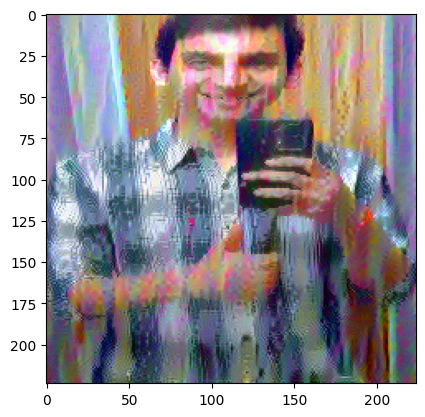

In [ ]:
final_img = deprocess_image(combination_image.numpy())
plt.imshow(final_img)
plt.show()